# Color Embeddings

In [1]:
%matplotlib inline

from graph_utils import *
from color_utils import *
from PIL import Image, ImageDraw
import pickle
from pathlib import Path
import torch
import torch.autograd as autograd
from torch.autograd.variable import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import BatchNorm1d
from torch.utils.data import DataLoader, Dataset

import random
import matplotlib.pyplot as plt
import numpy as np
import math

GPU_NUM = 1
torch.cuda.set_device(GPU_NUM)
print(torch.cuda.get_device_name(GPU_NUM))

GeForce GTX 1060 6GB


# Load the survey results
Here the processed survey is loaded, name and colors tallied.

In [2]:
#import the cleaned up survey
survey_file = open("colorname_value.pl",'rb') 
survey = pickle.load(survey_file)
survey_file.close()

colors = set()
names = set()
for name, color8bit, _ in survey[:250000]:
    names.add(name)
    colors.add(color8bit)

#number of colors in the survey data
print(f"Unique colors values {len(colors)}")
#number of different color names
print(f"Unique color names {len(names)}")
print(f"Colors per name {len(colors)/len(names)}")


Unique colors values 248185
Unique color names 289
Colors per name 858.7716262975779


In [3]:
#This is the Torch dataset used to feed the model
#Each item consists of an anchor color, a positive example and a negative example
#A positive color is one that was given the same name in the survey
#A negative example is one that was given a different name

class ColorDataset(Dataset):
    def __init__(self, color_data):
        
        self.color_names = set()
        self.color_name_value = {}
        self.items = []
        
        for name, _, _ in color_data:
            self.color_names.add(name)
        
        self.color_names = list(self.color_names)
        
        for name in self.color_names:
            self.color_name_value[name] = set()
        
        for name, color8bit, _ in color_data:
            r,g,b = colorValueToRGB(color8bit, 8)
            self.color_name_value[name].add((r/255., g/255., b/255.))
            
        for color_name, color_values in self.color_name_value.items():
            for color_value in color_values:
                self.items.append((color_name, color_value))
  
    def __getitem__(self, index):
        item = self.items[index]
        color_name = item[0]
        anchor_value = item[1]
        color_values = list(self.color_name_value[color_name])
        positive_value = random.choice(color_values)
        negative_value = None
        
        while True:
            neg_name = random.choice(self.color_names)
            if color_name != neg_name:
                color_values = list(self.color_name_value[neg_name])
                negative_value = random.choice(color_values)
                break
                
        assert negative_value != None
        return (torch.tensor(anchor_value), torch.tensor(positive_value), torch.tensor(negative_value))

    def __len__(self):
        return len(self.items)

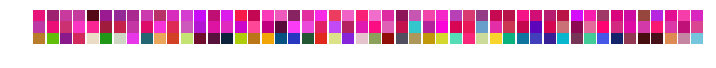

In [27]:
#Create the training and validation dataloaders

training_portion = int(len(survey)*0.9)
train_dataset = ColorDataset(survey[:training_portion])
train_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        batch_size=1000)

val_dataset = ColorDataset(survey[training_portion:10000])
val_dataloader = DataLoader(val_dataset,
                        shuffle=False,
                        batch_size=100)

#Let's visualize the training data
images = []
square_side = 50
for j in range(50):
    image = PIL.Image.new('RGB', (square_side, 3*square_side), color=0)
    draw = PIL.ImageDraw.Draw(image)
    colors = train_dataset[j]
    for i in range(3):
        color = colors[i].numpy()
        color = (int(color[0]*255),int(color[1]*255),int(color[2]*255))
        rect = [0, i*square_side, square_side, (i+1)*square_side]
        draw.rectangle(rect, fill=color)
    images.append(image)

from matplotlib.pyplot import figure, imshow, axis

fig = figure()
fig.set_size_inches((12,4))
for i in range(len(images)):
    a=fig.add_subplot(1, len(images),i+1)
    imshow(images[i])
    axis('off')

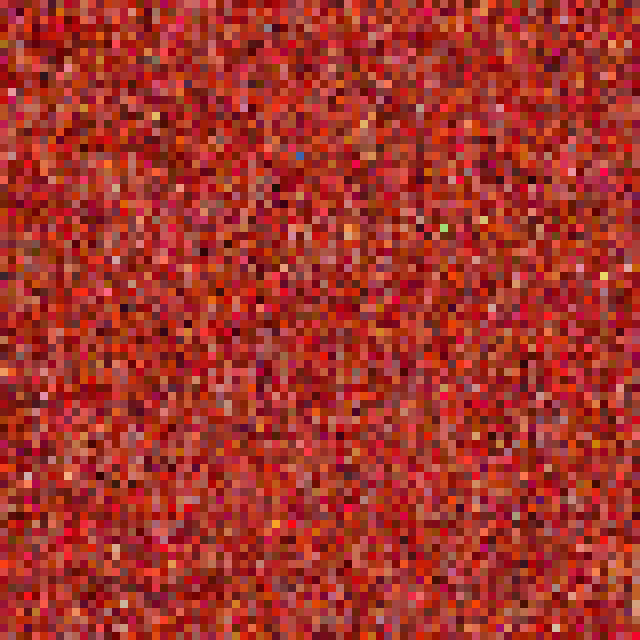

In [17]:
#Check some colors with the same names
colors = list(train_dataset.color_name_value["brick"])
side_len = int(math.sqrt(len(colors)))
square_len = 8
image_len = int(side_len*square_len)
image = PIL.Image.new('RGB', (image_len, image_len), color=0)
draw = PIL.ImageDraw.Draw(image)

for i in range(side_len):
    for j in range(side_len):
        r,g,b = colors[i*side_len+j]
        color = (int(r*255),int(g*255),int(b*255))
        rect = [i*square_len, j*square_len, i*square_len+square_len, j*square_len+square_len]
        draw.rectangle(rect, fill=color)
image

In [18]:
#check the shape of the data
viz_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        batch_size=2)
viz_batch = next(iter(viz_dataloader))
for i in range(3):
    print(viz_batch[i][0])

tensor([ 0.9490,  0.0431,  0.3765])
tensor([ 0.8902,  0.5255,  0.5451])
tensor([ 0.8627,  0.7216,  0.0902])


In [23]:
#Here's the network that will be trained
#It's a very simple fully connected network with batch normalization
class ColorModel(nn.Module):

    def __init__(self, color_dims, num_hidden):
        super(ColorModel, self).__init__()

        self.linear1 = nn.Linear(color_dims, num_hidden)
        self.linear2 = nn.Linear(num_hidden, num_hidden)
        self.linear3 = nn.Linear(num_hidden, num_hidden)
        self.linear4 = nn.Linear(num_hidden, color_dims)
        
        self.bn1 = nn.BatchNorm1d(num_hidden)
        self.bn2 = nn.BatchNorm1d(num_hidden)
        self.bn3 = nn.BatchNorm1d(num_hidden)

    def forwardOnce(self, inputs):
        out = self.bn1(F.relu(self.linear1(inputs)))
        out = self.bn2(F.relu(self.linear2(out)))
        out = self.bn3(F.relu(self.linear3(out)))
        out = F.relu(self.linear4(out))
        return out
    
    def forward(self, a, p, n):
        return (self.forwardOnce(a),
               self.forwardOnce(p),
               self.forwardOnce(n))
        
model = ColorModel(3, 50).cuda()

#Here is the triplet margin loss. It'll pull like colors together and push away negative examples
criterion = nn.TripletMarginLoss(margin=1.0).cuda()

In [34]:
#vars used in training
counter = []
training_history = []
validation_history = []
lr_history = []
cycles = 4
number_epochs = 20
itterations = 0

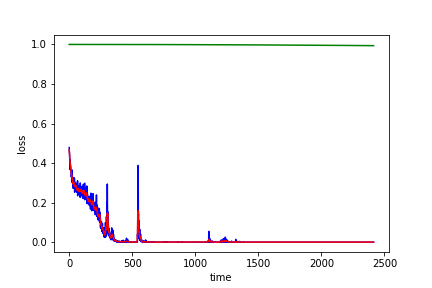

0.4551 0.4532 0.4428 0.4045 0.3887 0.4164 0.3669 0.4119 0.3927 0.3915 0.3836 0.3741 0.3733 0.3566 0.3584 0.3433 0.3304 0.3401 0.3384 0.3097 0.3586 0.3129 0.3345 0.3647 0.2987 0.3043 0.311 0.3116 0.2905 0.3048 0.3006 0.2719 0.2937 0.2794 0.3256 0.2859 0.2866 0.3244 0.2801 0.2995 0.3218 0.3007 0.2527 0.2743 0.2744 0.2858 0.2828 0.2891 0.3021 0.2813 0.289 0.2778 0.2806 0.2884 0.2785 0.2954 0.2539 0.269 0.2663 0.2621 0.2651 0.275 0.2539 0.2695 0.2589 0.3101 0.2346 0.2871 0.2659 0.2677 0.2619 0.2835 0.2749 0.2438 0.2567 0.2427 0.264 0.2707 0.2506 0.2702 0.2522 0.2594 0.2439 0.2831 0.2466 0.2273 0.2872 0.2991 0.263 0.2295 0.2511 0.2785 0.2525 0.255 0.2777 0.2815 0.2608 0.2546 0.2475 0.2595 0.2465 0.2688 0.2576 0.2358 0.2518 0.2794 0.2363 0.2381 0.2218 0.2371 0.2624 0.2918 0.2405 0.256 0.2669 0.2577 0.2848 0.2576 0.2375 0.2533 0.2178 0.2981 0.2146 0.2694 0.2157 0.2215 0.2408 0.2569 0.272 0.2337 0.2228 0.219 0.2278 0.2498 0.2643 0.2386 0.2501 0.2358 0.284 0.2648 0.2004 0.2327 0.1941 0.2459 0.2

ZeroDivisionError: division by zero

In [36]:
#Start the training loop
show_plot(counter, training_history)
lr = 0.002

#using a cyclic learning rate schedule
for cycle in range(cycles):
    optimizer = optim.Adam(model.parameters(), lr = lr)
    
    #The CosineAnnealingLR scheduler will decrease the lr over time. Then we reset the lr for each cycle
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, number_epochs*len(train_dataloader))

    for epoch in range(1, number_epochs+1):
        model.train()
        for i, data in enumerate(train_dataloader, 0):
            optimizer.zero_grad()
            #anchor, positive, negative
            a, p, n = data
            a, p, n = a.cuda(), p.cuda(), n.cuda()
            a, p, n = model(a, p, n)
            loss = criterion(a,p,n)
            loss.backward()
            optimizer.step()

            counter.append(itterations)
            itterations += 1
            loss_value = loss.item()
            training_history.append(loss_value)
            lr_history.append(scheduler.get_lr()[0] / lr)

            scheduler.step()
            print(f"{loss_value:0.4}", end=" ")
            update_plot(counter, training_history, lr_history)
        
        #check the validation set
        model.eval()
        average_loss = 0
        i = 0
        for data in val_dataloader:
            a, p, n = model(a, p, n)
            loss = criterion(a,p,n)
            average_loss += loss.item()
            i += 1
            
        average_loss = average_loss/i
        print(f"Validation loss {average_loss}")

In [126]:
results = []
with torch.no_grad():
    model.eval()
    for i in range(len(train_dataset)):
        color_in = train_dataset.items[i][1]
        tensor = torch.tensor(color_in).cuda()
        tensor = tensor.expand((1,3))
        color_out = model.forwardOnce(tensor)
        color_out = color_out.cpu().numpy()
        results.append((color_in, color_out))

In [1]:
from bokeh.plotting import figure, output_notebook, show

output_notebook() 
x = [1, 2, 3, 4, 5]
y = [6, 7, 2, 4, 5]
p = figure(title="simple line example", x_axis_label='x', y_axis_label='y')
p.line(x, y, legend="Temp.", line_width=2)
show(p)

Loading BokehJS ...

Widget Javascript not detected.  It may not be installed or enabled properly.


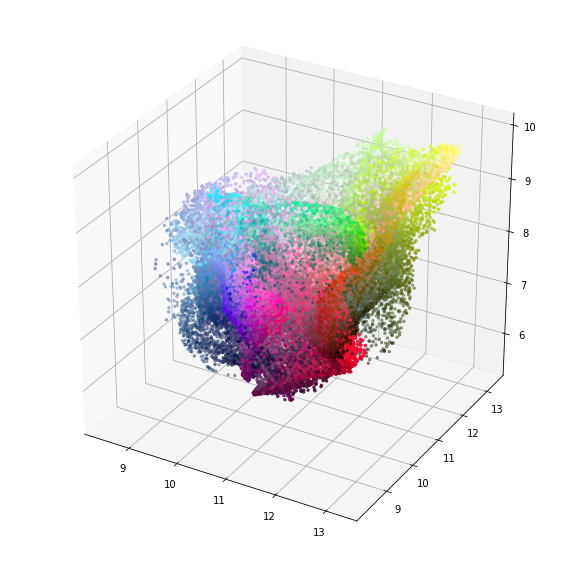

In [136]:
%matplotlib ipympl
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x = []
y = []
z = []
colors = []
for color_in, color_out in results:
    color_out = color_out.squeeze()
    #r, g, b = color_in
    #colors.append((color_out[0], color_out[1], color_out[2]))
    colors.append(color_in)
    x.append(color_out[0])
    y.append(color_out[1])
    z.append(color_out[2])
    
ax.scatter(x, y, z, c=colors, s=6)
plt.show()

# Fake survey data
The original survey is far too big and complex to dive into right away.
We should start with a much simpler problem.
Let make a fake survey with one name per color and three bits per color.
Heres the color map:

|R,G,B | name    | number |
|:----:|:--------|--------|
|0,0,0 | black   |   0    |
|0,0,1 | blue    |   1    |
|0,1,0 | green   |   2    |
|0,1,1 | cyan    |   3    |
|1,0,0 | red     |   4    |
|1,0,1 | magenta |   5    |
|1,1,0 | yellow  |   6    |
|1,1,1 | white   |   7    |


In [6]:
#fake survey data
names = ['black','blue','green','cyan','red','magenta','yellow', 'white']
colors = [x for x in range(len(names))]
survey = [(i, names[i]) for i in [random.randint(0,7) for _ in range(10000)]]


# Create the netowork

In [4]:
color_vector_size = 1

float_dtype = torch.cuda.FloatTensor
long_dtype = torch.cuda.LongTensor

#don't one hot encode, CrossEntropyLoss wants a category index
name_to_idx = {name:i for i, name in enumerate(names)}

#the embedding class will take care of this for us
color_to_idx = {name:i for i, name in enumerate(colors)}

best_weights_filename = 'best_training.pt'

class ColorModel(nn.Module):

    def __init__(self, color_dims, num_colors, num_hidden, num_color_names):
        super(ColorModel, self).__init__()
        self.embeddings = nn.Embedding(num_colors, color_dims)
        self.linear1 = nn.Linear(color_dims, num_hidden)
        self.linear2 = nn.Linear(num_hidden, num_color_names)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        return out
        
model = ColorModel(color_vector_size, len(colors), 64, len(names))
#model.load_state_dict(torch.load(best_weights_filename))

best_loss = 100

In [6]:
def printEmbeddings(embeddings, num_embed, embed_dim):
    embeds = np.zeros((num_embed, embed_dim))
    for i in range(num_embed):
        input = Variable(torch.LongTensor([i]))
        embeds[i] = model.embeddings(input).data.numpy()
    
    print(embeds)
        
printEmbeddings(model.embeddings.cpu(), len(colors), color_vector_size)

[[-1.57306981]
 [ 0.22013998]
 [ 0.2350595 ]
 [ 1.00439644]
 [ 0.43517509]
 [-0.04591999]
 [ 0.74104834]
 [ 0.59757715]]


In [30]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

loss_function = nn.CrossEntropyLoss()
learning_rate = 0.25
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
def fit(survey, batch_size):
    total_loss = 0
    accuracy = 0
    num_batches = len(survey)//batch_size
    for t in range(num_batches):
        idx = t*batch_size
        
        idx_range = range(idx, idx+batch_size)

        input_tensor = [color_to_idx[survey[i][0]] for i in idx_range]
        output_tensor = [name_to_idx[survey[i][1]] for i in idx_range]
        
        input_var = Variable(torch.LongTensor(input_tensor)).cuda()
        output_var = Variable(torch.LongTensor(output_tensor)).cuda()

        #Forward pass: compute predicted y by passing x to the model.
        y_pred = model(input_var)
        # Compute and print loss.
        
        loss = loss_function(y_pred, output_var)
        
        scheduler.step(loss.data[0])
        
        total_loss = total_loss + loss.data[0]
        
        #calculate the accuracy
        preds = y_pred.cpu().data.numpy()
        preds = np.argmax(softmax(preds), axis=1)
        out = output_var.cpu().data.numpy()
        
        accuracy += np.sum( preds == out)
        #print(preds)
        #print(out)
        #print(f"output {output_var.shape} y_pred {y_pred.shape}")

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable weights
        # of the model)
        model.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
    
    return (total_loss/num_batches, accuracy/(num_batches*batch_size))

In [31]:
best = 0.1
model = model.cuda()
batch_size = min(len(survey), 1000)
for b in range(100000):
    loss, accuracy = fit(survey, batch_size)
    #print(f"loss {loss} accuracy {accuracy}")
    #print(f"embedding {model.embeddings(Variable(torch.LongTensor([0]).cuda()))}")
    if b %1000 == 0:
        print(f'accuracy {accuracy}')
    if accuracy > best:
        best = accuracy
        print(f"new best accuracy = {best}, saving file") 
        torch.save(model.state_dict(), best_weights_filename)


accuracy 0.9501
new best accuracy = 0.9501, saving file
new best accuracy = 1.0, saving file
accuracy 1.0
accuracy 1.0


KeyboardInterrupt: 

In [32]:
printEmbeddings(model.embeddings.cpu(), len(colors), color_vector_size)

[[-6.8437891 ]
 [-0.1198705 ]
 [-0.75035083]
 [ 5.29726171]
 [-1.04187715]
 [-3.36242938]
 [ 2.65659332]
 [ 1.5692265 ]]


After training we get an accuracy of 16%. To put this into context, there are 4.5 names per color. The best we can do is about 20%. I appears to be working.

# Normalize the embeddings

In [24]:
# extract the values
embeds = np.zeros((len(colors), color_vector_size))
for i in range(len(colors)):
    input = Variable(torch.LongTensor([i]).cuda())
    embeds[i] = model.embeddings(input).cpu().data.numpy()

# Normalize to 0-1 range
embeds = embeds + (embeds.min() * -1)
embeds = embeds / embeds.max()

embeds

array([[ 1.44354284, -0.45639139,  0.04452125],
       [-0.55458272,  1.21346593, -0.55216134],
       [ 1.32680035, -0.55482036, -1.12035072],
       [-0.26890165,  0.36302796, -0.22699776],
       [ 1.79286122, -0.09863987, -0.42609769],
       [ 1.05445981, -1.35040557,  0.06296504],
       [ 0.01505214,  0.27168888, -0.46650663],
       [ 0.51472127,  0.20095883,  1.45397246]])

# Visualize the original colors

In [118]:
for _, color8bit, color2bit in survey[:50]:
    print(colorValueToRGB(color8bit, 8))

(72, 100, 175)
(182, 226, 245)
(130, 64, 234)
(75, 49, 234)
(76, 215, 249)
(111, 145, 122)
(88, 70, 1)
(218, 35, 156)
(154, 42, 159)
(179, 67, 229)
(92, 97, 190)
(116, 208, 126)
(9, 2, 21)
(69, 255, 41)
(27, 34, 98)
(41, 201, 234)
(99, 212, 32)
(160, 89, 66)
(204, 117, 64)
(12, 208, 219)
(73, 97, 236)
(131, 79, 90)
(209, 202, 95)
(77, 147, 83)
(136, 30, 75)
(33, 115, 229)
(232, 171, 51)
(99, 46, 219)
(212, 209, 208)
(56, 188, 125)
(197, 164, 25)
(242, 9, 26)
(221, 240, 210)
(199, 254, 247)
(186, 117, 237)
(63, 137, 94)
(102, 192, 226)
(147, 120, 33)
(14, 47, 164)
(188, 118, 237)
(100, 251, 74)
(204, 102, 34)
(64, 128, 225)
(221, 16, 55)
(183, 212, 152)
(58, 187, 13)
(10, 63, 178)
(164, 146, 98)
(74, 89, 253)
(203, 69, 189)


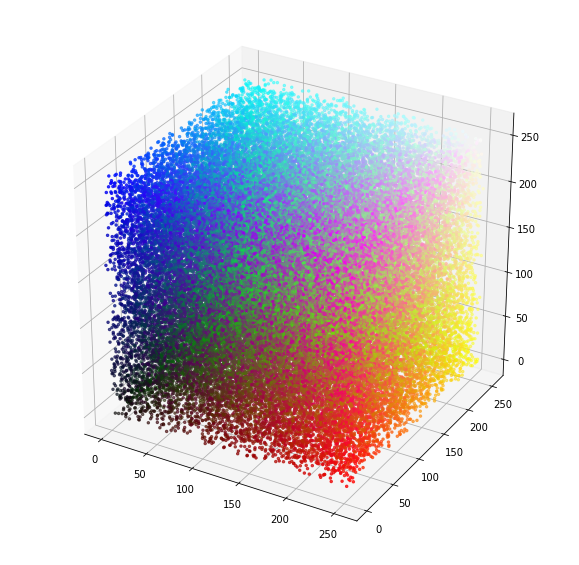